In [1]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [2]:
# ---------------------------
# 环境定义
# ---------------------------
class UAVEnv:
    def __init__(self):
        # 地点表示: 0: L0 (Home), 1: L1, 2: L2
        # 物理参数
        self.d_L0_L1 = 10
        self.d_L0_L2 = 20
        self.d_L1_L2 = 15  # 假设 L1 到 L2距离（对称）
        self.charging_rate = 20  # 充电速率
        self.remove_cost = 5     # 消除警报消耗能量（可调）
        self.battery_capacity = 80
        
        # 警报生成概率（独立变量）
        self.p_L1 = 0.017
        self.p_L2 = 0.012


        # 调整惩罚和奖励参数
        self.max_alarm_age = 120  # 降低最大等待时间
        self.anchor_penalty = 1000  # 降低抛锚惩罚
        self.max_age_penalty = 800
        self.clear_reward_base = 10  # 降低基础奖励

        # 定义最大步数
        self.max_steps = 10000      
        self.alarm_penalty_rate = 2  # 降低持续惩罚
        
        self.reset()

    def reset(self):
        # 当前时间步
        self.t = 0
        # UAV位置，初始在L0(Home)
        self.pos = 0
        # 充满电
        self.battery = self.battery_capacity
        
        # 对每个地点的警报状态：如果有警报，记录等待时间（初始值为1）
        # 如果没有警报，记为0
        self.alarm_L1 = 0  
        self.alarm_L2 = 0  
        
        # 累计 AoMA
        self.aoa_total = 0
        # 为统计每个警报的 AoMA，存储 (地点, waiting_time)，
        # 当报警被清除时，计算代价: waiting_time*(waiting_time+1)/2
        # 但这里我们只累加至 self.aoa_total
        # episode 中是否因能量不足抛锚
        self.anchored = False
        # 本 episode 警报总次数
        self.alarm_count = 0
        self.stop_reason = "NO"
        return self._get_state()

    def _get_state(self):
        # 状态: [当前所在位置(one-hot 3维), 剩余电量归一化, alarm_L1等待时间归一化, alarm_L2等待时间归一化]
        pos_onehot = [1 if self.pos == i else 0 for i in range(3)]
        norm_battery = self.battery / self.battery_capacity
        # 用最大允许等待时长做归一化并截断到 [0,1]
        norm_alarm1 = min(self.alarm_L1, self.max_alarm_age) / self.max_alarm_age
        norm_alarm2 = min(self.alarm_L2, self.max_alarm_age) / self.max_alarm_age
        state = np.array(pos_onehot + [norm_battery, norm_alarm1, norm_alarm2], dtype=np.float32)
        return state

    def _get_distance(self, from_pos, to_pos):
        if from_pos == to_pos:
            return 0
        if {from_pos, to_pos} == {0, 1}:
            return self.d_L0_L1
        if {from_pos, to_pos} == {0, 2}:
            return self.d_L0_L2
        if {from_pos, to_pos} == {1, 2}:
            return self.d_L1_L2
        return 0

    def step(self, action):
        """
        动作定义:
         0: 移动到 L0 (如果已在L0，则代表在Home充电)
         1: 移动到 L1
         2: 移动到 L2
         3: 执行消除警报动作（前提是在对应地点且有警报）
        """
        reward = 0.0

        # 默认时间步增量为1
        delta_time = 1

        # 处理动作
        if action in [0, 1, 2]:
            target = action  # 目标地点
            if self.pos != target:
                # 计算移动需要的耗时和能量
                dist = self._get_distance(self.pos, target)
                # 如果电量不足以完成移动，则 UAV 抛锚，episode结束
                if self.battery < dist:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                # 飞行过程消耗能量
                self.battery -= dist
                delta_time = dist
                self.pos = target
            # 如果移动到 L0，则代表可以充电
            if self.pos == 0:
                charge = self.charging_rate * delta_time
                self.battery = min(self.battery + charge, self.battery_capacity)
        elif action == 3:
            # 执行消除警报动作
            if self.pos == 1 and self.alarm_L1 > 0:
                # 检查电量是否充足进行消除
                if self.battery < self.remove_cost:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                self.battery -= self.remove_cost
                t = self.alarm_L1
                # 累积 AoMA 统计
                self.aoa_total += t * (t + 1) / 2
                # 改进奖励：基于时间给予更合理的奖励
                time_bonus = max(5, 60 - (self.alarm_L1+1)*(self.alarm_L1+2)/40)   # 时间越短奖励越高
                reward += time_bonus
                self.alarm_L1 = 0
            elif self.pos == 2 and self.alarm_L2 > 0:
                if self.battery < self.remove_cost:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                self.battery -= self.remove_cost
                t = self.alarm_L2
                self.aoa_total += t * (t + 1) / 2
                time_bonus = max(5, 60 - (self.alarm_L2+1)*(self.alarm_L2+2)/40)  # 时间越短奖励越高
                reward += time_bonus
                self.alarm_L2 = 0
            else:
                # 无效的消除动作
                reward -= 20
        else:
            # 非法动作
            reward -= 20

        # 新：对每个时间步进行逐步模拟，确保每一步都尝试生成警报
        for _ in range(delta_time):
            # 更新全局时间
            self.t += 1
            
            # 更新现有警报的等待时间
            if self.alarm_L1 > 0:
                self.alarm_L1 += 1
            if self.alarm_L2 > 0:
                self.alarm_L2 += 1

            # 计算惩罚
            alarm_penalty = 0
            if self.alarm_L1 > 0:
                alarm_penalty +=  self.alarm_penalty_rate*(0.8+ 1.5*self.alarm_L1/self.max_alarm_age)  # 增加惩罚随着等待时间增加
            if self.alarm_L2 > 0:
                alarm_penalty +=  self.alarm_penalty_rate*(0.8+ 1.5*self.alarm_L2/self.max_alarm_age)  # 增加惩罚随着等待时间增加
            reward -= alarm_penalty
            
            # 检查警报是否超过最大等待时间
            if self.alarm_L1 > self.max_alarm_age or self.alarm_L2 > self.max_alarm_age:
                self.maxed = True
                self.stop_reason = "AoMA_MAX"
                reward -= self.max_age_penalty
                return self._get_state(), reward, True, {"info": "max_age_exceeded"}
            
            # 尝试生成新的警报（每个时间步都检查）
            if self.alarm_L1 == 0 and random.random() < self.p_L1:
                self.alarm_L1 = 1
                self.alarm_count += 1
            if self.alarm_L2 == 0 and random.random() < self.p_L2:
                self.alarm_L2 = 1
                self.alarm_count += 1

        # 添加电量安全奖励
        if self.battery > 20:
            reward += 0.1  # 保持充足电量的奖励
        elif self.battery <= 20:
            reward -= (self.battery_capacity - self.battery) - 60  # 电量过低的惩罚

        # 如果超出最大步数或电量耗尽，则结束episode
        done = False
        if self.t >= self.max_steps or self.battery <= 0:
            done = True
            self.stop_reason = "✅"  # 添加这行
            # 如果因电量耗尽而结束，则给予惩罚
            if self.battery <= 0:
                self.anchored = True
                self.stop_reason = "Anchored"
                reward -= self.anchor_penalty

        return self._get_state(), reward, done, {}

# ---------------------------
# DQN Agent 定义
# ---------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # 增加网络深度和宽度
        self.net = nn.Sequential(
                    nn.Linear(input_dim, 128),   # 增加到128
                    nn.ReLU(),
                    nn.Linear(128, 64),          # 新增一层64
                    nn.ReLU(),
                    nn.Linear(64, 32),           # 保持32
                    nn.ReLU(),
                    nn.Linear(32, output_dim)    # 输出层
                )
        
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=2e-4, gamma=0.96, epsilon_start=0.95,
                 epsilon_end=0.01, epsilon_decay=0.997, memory_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma  # 降低gamma，让agent更关注短期奖励
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay  # 更慢的epsilon衰减
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.update_target_steps = 200  # 更频繁的目标网络更新

        self.step_count = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qvals = self.policy_net(state)
        return int(torch.argmax(qvals, dim=1).item())

    def store_transition(self, transition):
        self.memory.append(transition)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states     = torch.FloatTensor(states).to(self.device)
        actions    = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards    = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states= torch.FloatTensor(next_states).to(self.device)
        dones      = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # 当前 Q
        qvals = self.policy_net(states).gather(1, actions)

        # Double DQN: 在线网路选动作，目标网路估值
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            next_qvals   = self.target_net(next_states).gather(1, next_actions)
            expected = rewards + self.gamma * next_qvals * (1 - dones)

        loss = self.loss_fn(qvals, expected)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        if self.step_count % self.update_target_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # ε 衰减
        # self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_end)

# ---------------------------
# 训练过程与可视化
# ---------------------------
def train(num_episodes=6000):  # 减少episode数量先观察效果
    env = UAVEnv()
    state_dim = 3 + 3  # 3位置(one-hot) + (battery, alarm1, alarm2)
    action_dim = 4   # 动作：移动到L0, L1, L2, 执行消除警报动作
    agent = DQNAgent(state_dim, action_dim)
    
    episode_rewards = []
    episode_aoa = []
    anchored_count = []     # 改为列表
    aoma_max_count = []     # 改为列表
    success_count = []  

    # 添加滑动窗口平均以观察趋势
    window_size = 100
    window_size = 100
    
    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        # 记录本episode累计 AoMA（环境内部已统计在 env.aoa_total 中）
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            # 终止判断：如果由于抛锚，则将 done 置 True并设置特殊标记
            done_flag = 1.0 if done else 0.0
            agent.store_transition((state, action, reward, next_state, done_flag))
            agent.update()
            state = next_state
            total_reward += reward
            steps += 1
            # 如果因电量不足抛锚，则提前退出
            if info.get("info", "") == "anchored":
                break

        episode_rewards.append(total_reward)
        # 平均 AoMA = 累积 AoMA / 本 episode 警报总次数
        avg_aoa = env.aoa_total / env.alarm_count if env.alarm_count > 0 else 0
        # 修改统计方式 - 每个episode记录0或1
        if env.stop_reason == "✅":
            episode_aoa.append((avg_aoa, ep))
            anchored_count.append(0)
            aoma_max_count.append(0)
            success_count.append(1)
        elif env.stop_reason == "AoMA_MAX":
            anchored_count.append(0)
            aoma_max_count.append(1)
            success_count.append(0)
        elif env.stop_reason == "Anchored":
            anchored_count.append(1)
            aoma_max_count.append(0)
            success_count.append(0)
        else:
            anchored_count.append(0)
            aoma_max_count.append(0)
            success_count.append(0)
    

        # 每50集打印一次详细信息
        #if (ep + 1) % 50 == 0:
        print(
            f"Episode {ep+1:4d} | Reward: {total_reward:10.2f}"
            f" | Avg AoMA: {avg_aoa:8.2f} ({env.aoa_total:8} / {env.alarm_count:2d})"
            f" | Early Stop: {env.stop_reason}"
            f" | Stopped at: {env.t}"
            f" | epsilon: {agent.epsilon:.4f}"
        )
# 每个 episode 结束后再进行一次 epsilon 衰减
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_end)

    return agent, episode_rewards, episode_aoa, anchored_count, aoma_max_count, success_count

agent, rewards, aoa, anchors, aoma_max, success = train()

Episode    1 | Reward:   -1200.63 | Avg AoMA:     1.00 (     3.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 140 | epsilon: 0.9500
Episode    2 | Reward:   -1482.85 | Avg AoMA:  1644.00 (  4932.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 254 | epsilon: 0.9471
Episode    3 | Reward:   -1356.39 | Avg AoMA:   345.00 (  1035.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 141 | epsilon: 0.9443
Episode    4 | Reward:   -1283.27 | Avg AoMA:   800.33 (  2401.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 113 | epsilon: 0.9415
Episode    5 | Reward:   -1099.12 | Avg AoMA:     5.00 (    10.0 /  2) | Early Stop: AoMA_MAX | Stopped at: 108 | epsilon: 0.9387
Episode    6 | Reward:   -1776.97 | Avg AoMA:  1079.29 (  7555.0 /  7) | Early Stop: AoMA_MAX | Stopped at: 445 | epsilon: 0.9358
Episode    7 | Reward:   -1408.83 | Avg AoMA:  2002.50 (  4005.0 /  2) | Early Stop: Anchored | Stopped at: 173 | epsilon: 0.9330
Episode    8 | Reward:   -1370.86 | Avg AoMA:   451.50 (   903.0 /  2) | Early Stop: AoMA_

/var/folders/y8/6wsnwdks5qjbpgkbrp2ysk3r0000gp/T/ipykernel_17382/2633386783.py:258: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states     = torch.FloatTensor(states).to(self.device)


Episode   15 | Reward:   -1173.20 | Avg AoMA:     0.00 (       0 /  1) | Early Stop: AoMA_MAX | Stopped at: 122 | epsilon: 0.9109
Episode   16 | Reward:   -2245.20 | Avg AoMA:  1295.67 (  7774.0 /  6) | Early Stop: AoMA_MAX | Stopped at: 585 | epsilon: 0.9081
Episode   17 | Reward:   -1176.36 | Avg AoMA:    84.33 (   253.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 165 | epsilon: 0.9054
Episode   18 | Reward:   -1461.12 | Avg AoMA:   360.33 (  1081.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 181 | epsilon: 0.9027
Episode   19 | Reward:   -1155.22 | Avg AoMA:   826.50 (  1653.0 /  2) | Early Stop: Anchored | Stopped at: 70 | epsilon: 0.9000
Episode   20 | Reward:   -1204.40 | Avg AoMA:     0.33 (     1.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 180 | epsilon: 0.8973
Episode   21 | Reward:   -1321.45 | Avg AoMA:     0.00 (       0 /  2) | Early Stop: AoMA_MAX | Stopped at: 117 | epsilon: 0.8946
Episode   22 | Reward:   -1809.81 | Avg AoMA:  2353.75 (  9415.0 /  4) | Early Stop: AoMA_M

Test Ep    1 | Reward:    2565.20 | Avg AoMA:   242.29 (   59118/244) | Early Stop: ✅ | Stopped at: 10012 | epsilon: 0.0000
Test Ep    2 | Reward:    3882.86 | Avg AoMA:   213.32 (   51409/241) | Early Stop: ✅ | Stopped at: 10008 | epsilon: 0.0000
Test Ep    3 | Reward:    2501.94 | Avg AoMA:   242.59 (   55069/227) | Early Stop: ✅ | Stopped at: 10000 | epsilon: 0.0000
Test Ep    4 | Reward:    3259.07 | Avg AoMA:   217.23 (   46053/212) | Early Stop: ✅ | Stopped at: 10002 | epsilon: 0.0000
Test Ep    5 | Reward:    2916.92 | Avg AoMA:   231.80 (   52618/227) | Early Stop: ✅ | Stopped at: 10002 | epsilon: 0.0000
Test Ep    6 | Reward:    3543.45 | Avg AoMA:   213.23 (   50536/237) | Early Stop: ✅ | Stopped at: 10009 | epsilon: 0.0000
Test Ep    7 | Reward:    3227.40 | Avg AoMA:   230.83 (   55862/242) | Early Stop: ✅ | Stopped at: 10009 | epsilon: 0.0000
Test Ep    8 | Reward:    2970.31 | Avg AoMA:   232.72 (   55853/240) | Early Stop: ✅ | Stopped at: 10010 | epsilon: 0.0000
Test Ep 

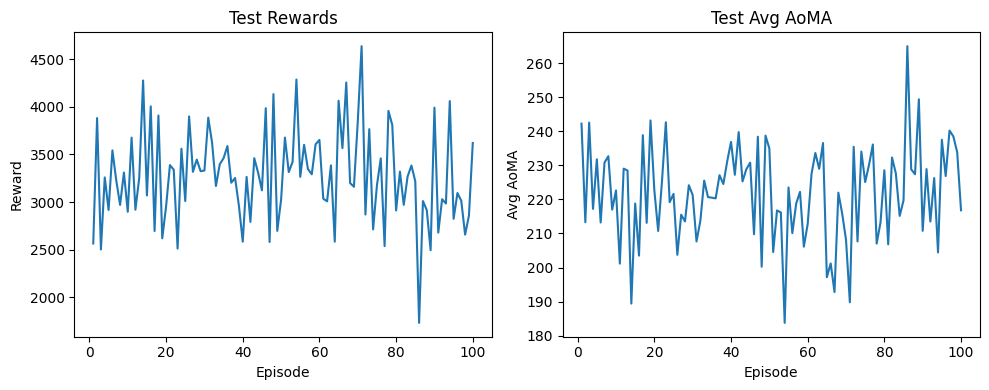

In [7]:
# --- 修改后的测试函数，不使用探索 (epsilon=0)，并打印每集信息 ---
def test(agent, num_episodes=1000):
    env = UAVEnv()
    agent.epsilon = 0.0
    rewards, aoas = [], []
    anchored = 0

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward


        avg_aoa = env.aoa_total / env.alarm_count if env.alarm_count > 0 else 0
        rewards.append(total_reward)
        aoas.append(avg_aoa)
        if env.anchored:
            anchored += 1

        # 每集打印详细信息
        print(
            f"Test Ep {ep+1:4d} | Reward: {total_reward:10.2f}"
            f" | Avg AoMA: {avg_aoa:8.2f} ({env.aoa_total:8.0f}/{env.alarm_count:2d})"
            f" | Early Stop: {env.stop_reason}"
            f" | Stopped at: {env.t}"
            f" | epsilon: {agent.epsilon:.4f}"
        )

    # 汇总结果
    print(f"\nTest over {num_episodes} episodes")
    print(f"Average Reward : {np.mean(rewards):.2f}")
    print(f"Average AoMA   : {np.mean(aoas):.2f}")
    print(f"Anchored Count : {anchored} ({anchored/num_episodes*100:.1f}%)")

    # 可视化
    episodes = np.arange(1, num_episodes+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(episodes, rewards)
    plt.title("Test Rewards")
    plt.xlabel("Episode"); plt.ylabel("Reward")
    plt.subplot(1,2,2)
    plt.plot(episodes, aoas)
    plt.title("Test Avg AoMA")
    plt.xlabel("Episode"); plt.ylabel("Avg AoMA")
    plt.tight_layout()
    plt.show()

# 执行测试

test(agent, num_episodes=100)

# …existing code…
#

In [5]:
import torch
model_path = "uav_dqn.pth"
torch.save(agent.policy_net.state_dict(), model_path)
print(f"Saved policy net to {model_path}")

Saved policy net to uav_dqn.pth


In [36]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

# ---------------------------
# 独立绘制并保存为PDF的可视化函数 (与前面图表风格一致)
# ---------------------------
def plot_and_save_training_results(rewards, aoa, anchors, aoma_max, success, window_size=100):
    episodes = np.arange(1, len(rewards)+1)
    
    # 定义与前面图表一致的样式设置
    plot_template = 'plotly_white'  # 干净的白色背景，适合学术发表
    line_width = 2.5
    marker_size = 8
    # font_family = "Arial, sans-serif"  # IEEE首选字体
    font_family = "Times New Roman, serif"  # 更适合学术论文
    title_font_size = 18
    axis_font_size = 18
    legend_font_size = 16
    
    def moving_average(data, window):
        return pd.Series(data).rolling(window=window, min_periods=1).mean().values
    
    rewards_ma = moving_average(rewards, window_size)
    anchors_ma = moving_average(anchors, window_size)
    aoma_max_ma = moving_average(aoma_max, window_size)
    success_ma = moving_average(success, window_size)
    
    # 1. Reward Curve
    fig1 = go.Figure()
    
    # 原始数据作为背景（半透明）
    fig1.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards,
            mode='lines',
            name='Raw Reward',
            line=dict(color='rgba(0, 114, 178, 0.3)', width=line_width/2),
            showlegend=True
        )
    )
    
    # 滑动平均（醒目颜色）
    fig1.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards_ma,
            mode='lines',
            name=f'Reward MA({window_size})',
            line=dict(color='rgba(0, 114, 178, 1)', width=line_width),
            showlegend=True
        )
    )
    
    # 更新布局，保持与前面图表一致的风格
    fig1.update_layout(
        template=plot_template,
        title=dict(
            text='<b>Training Reward Curve</b>',
            font=dict(size=title_font_size, family=font_family)
        ),
        height=500,
        width=600,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=legend_font_size)
        ),
        margin=dict(l=80, r=40, t=80, b=80),
        xaxis=dict(
            title=dict(text="<b>Episode</b>", font=dict(size=axis_font_size, family=font_family)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title=dict(text="<b>Reward</b>", font=dict(size=axis_font_size, family=font_family)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        )
    )
    
    # 保存为PDF
    fig1.write_image("reward_curve.pdf", format="pdf")
    fig1.show()
    
    # 2. AoMA Curve (仅成功完成的episodes)
    fig2 = go.Figure()
    
    if aoa and len(aoa) > 0:  # 确保有成功完成的episode数据
        # 提取episode索引和对应的AoMA值
        aoa_episodes = [item[1] + 1 for item in aoa]  # episode索引 (从1开始显示)
        aoa_values = [item[0] for item in aoa]        # AoMA值
        
        # 计算AoMA的滑动平均 (如果有足够数据)
        window_size_aoa = min(window_size, len(aoa_values))
        if window_size_aoa > 0:
            aoa_ma = moving_average(aoa_values, window_size_aoa)
            
            # 原始AoMA数据（半透明）- 修改为带线条的散点
            fig2.add_trace(
                go.Scatter(
                    x=aoa_episodes,
                    y=aoa_values,
                    mode='lines',  # 修改为线条+标记点
                    name='Raw AoMA',
                    line=dict(color='rgba(213, 94, 0, 0.3)', width=line_width/2),  # 添加线条样式            
                    showlegend=True
                )
            )
            
            # AoMA滑动平均
            fig2.add_trace(
                go.Scatter(
                    x=aoa_episodes[:len(aoa_ma)],
                    y=aoa_ma,
                    mode='lines',
                    name=f'AoMA MA({window_size_aoa})',
                    line=dict(color='rgba(213, 94, 0, 1)', width=line_width),
                    showlegend=True
                )
            )
        else:
            # 只有原始数据点 - 同样修改为带线条的散点
            fig2.add_trace(
                go.Scatter(
                    x=aoa_episodes,
                    y=aoa_values,
                    mode='lines+markers',  # 修改为线条+标记点
                    name='AoMA',
                    line=dict(color='rgba(213, 94, 0, 0.8)', width=line_width/2),  # 添加线条样式
                    marker=dict(color='rgba(213, 94, 0, 1)', size=marker_size),
                    showlegend=True
                )
            )
    else:
        # 添加文本提示
        fig2.add_annotation(
            text="No successful episodes",
            x=0.5, y=0.5,
            xref="paper", yref="paper",
            showarrow=False,
            font=dict(size=16, color="gray", family=font_family)
        )
    
    # 更新布局
    fig2.update_layout(
        template=plot_template,
        title=dict(
            text='<b>Average AoMA for Successful Episodes</b>',
            font=dict(size=title_font_size, family=font_family)
        ),
        height=500,
        width=600,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=legend_font_size)
        ),
        margin=dict(l=80, r=40, t=80, b=80),
        xaxis=dict(
            title=dict(text="<b>Episode</b>", font=dict(size=axis_font_size, family=font_family)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title=dict(text="<b>Average AoMA</b>", font=dict(size=axis_font_size, family=font_family)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        )
    )
    
    # 保存为PDF
    fig2.write_image("aoma_curve.pdf", format="pdf")
    fig2.show()
    
    # 3. Early Stop Types
    fig3 = go.Figure()
    
    # 定义专业的颜色方案
    anchored_color = 'rgba(44, 160, 44, 0.8)'  # 绿色
    aoma_max_color = 'rgba(214, 39, 40, 0.8)'  # 红色
    success_color = 'rgba(31, 119, 180, 0.8)'  # 蓝色
    
    # 原始数据点 - 使用小的半透明点
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors,
            mode='markers',
            name='Anchored (Raw)',
            marker=dict(color='rgba(44, 160, 44, 0.2)', size=3),
            showlegend=False
        )
    )
    
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max,
            mode='markers',
            name='AoMA Max (Raw)',
            marker=dict(color='rgba(214, 39, 40, 0.2)', size=3),
            showlegend=False
        )
    )
    
    # 滑动平均线
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors_ma,
            mode='lines',
            name='Anchored',
            line=dict(color=anchored_color, width=line_width),
            showlegend=True
        )
    )
    
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max_ma,
            mode='lines',
            name='AoMA Max',
            line=dict(color=aoma_max_color, width=line_width),
            showlegend=True
        )
    )
    
    # 成功率滑动平均线
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=success_ma,
            mode='lines',
            name='Success Rate',
            line=dict(color=success_color, width=line_width),
            showlegend=True
        )
    )
    
    # 更新布局
    fig3.update_layout(
        template=plot_template,
        title=dict(
            text='<b>Early Stop Types Analysis</b>',
            font=dict(size=title_font_size, family=font_family)
        ),
        height=500,
        width=600,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=legend_font_size)
        ),
        margin=dict(l=80, r=40, t=80, b=80),
        xaxis=dict(
            title=dict(text="Episode", font=dict(size=axis_font_size)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title=dict(text="Rate", font=dict(size=axis_font_size)),
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True
        )
    )
    
    # 保存为PDF
    fig3.write_image("early_stop_analysis.pdf", format="pdf")
    fig3.show()
    
    print("PDF files saved:")
    print("- reward_curve.pdf")
    print("- aoma_curve.pdf") 
    print("- early_stop_analysis.pdf")

# 这里保留原来调用函数的代码
plot_and_save_training_results(rewards, aoa, anchors, aoma_max, success, window_size=100)

PDF files saved:
- reward_curve.pdf
- aoma_curve.pdf
- early_stop_analysis.pdf
